# Урок 6. Двухуровневые модели рекомендаций


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender


### Read data

In [2]:
# data = pd.read_csv('../data/retail_train.csv')
# item_features = pd.read_csv('../data/product.csv')
# user_features = pd.read_csv('../data/hh_demographic.csv')

data = pd.read_csv('recsys_retail_train.csv')
item_features = pd.read_csv('recsys_product.csv')
user_features = pd.read_csv('recsys_hh_demographic.csv')

### Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

### Split dataset for train, eval, test

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
data['week_no'].max()

95

In [7]:
# 0-85
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# 86-91
# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# 92-95
# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [8]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [9]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


### Prefilter items

In [10]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\Anokiro\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


### Make cold-start to warm-start

In [11]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


In [12]:
# Теперь warm-start по пользователям

### Init/train recommender

In [13]:
recommender = MainRecommender(data_train_matcher)

### Eval recall of matching

## Задание 1.

### A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?


In [14]:
ACTUAL_COL = 'actual'

In [15]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [16]:
# N = Neighbors
N_PREDICT = 100

In [17]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

Wall time: 37.5 s


In [18]:
%%time
result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=N_PREDICT))

Wall time: 15min


In [ ]:
result_eval_matcher.head(3)

In [19]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [20]:
%%time
popular_recs = popularity_recommendation(data_val_matcher, n=N_PREDICT)

result_eval_matcher['popular_rec'] = result_eval_matcher['user_id'].apply(lambda x: popular_recs)
result_eval_matcher.head(2)

Wall time: 23 ms


,user_id,actual,own_rec,sim_item_rec,als_rec,sim_user_rec,popular_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[990335, 5582712, 9297615, 5577022, 920200, 98...","[1003649, 856942, 1047619, 1037332, 841584, 95...","[6552318, 979674, 6514085, 1135983, 997987, 80...","[6534178, 6533889, 1029743, 6534166, 6533765, ..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[916122, 919534, 5569230, 9487885, 996087, 978...","[1091090, 9419422, 1092937, 971474, 1013578, 9...","[6534178, 6533889, 1029743, 6534166, 6533765, ..."


In [21]:
def weighted_random_recommendation(data, target_for_freq='item_id', n=5):
    """Случайные взвешенные рекоммендации"""
    
    # В данном алгоритме товары отбираются на основании популярности товаров.
    dict_ = {}
    len_data = len(data)
    for item, counts in zip(data[target_for_freq].value_counts().index, data[target_for_freq].value_counts()):
        dict_[item] = np.log(len_data / counts) * (1 - (counts / len_data ))
    
    tmp_data = pd.DataFrame(data=dict_.items(), columns=['item', 'weight'])
    
    tmp_data['weight'] = tmp_data['weight'] / tmp_data['weight'].sum()
        
    items = np.array(tmp_data['item'].unique())
    
    # n * 2
    recs = np.random.choice(items, size=n*2, replace=False)
    
    #ascending=False -> антипопулярность, ascending=True -> популярность
    recs_final = tmp_data.loc[tmp_data['item'].isin(recs)].sort_values(by='weight', ascending=True)['item'][:n]
    
    return recs_final.tolist()

In [22]:
%%time
result_eval_matcher['weighted_random_rec'] = result_eval_matcher['user_id'].apply(lambda x: weighted_random_recommendation(data_val_matcher, n=N_PREDICT))
result_eval_matcher.head(2)

Wall time: 3min 2s


,user_id,actual,own_rec,sim_item_rec,als_rec,sim_user_rec,popular_rec,weighted_random_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[990335, 5582712, 9297615, 5577022, 920200, 98...","[1003649, 856942, 1047619, 1037332, 841584, 95...","[6552318, 979674, 6514085, 1135983, 997987, 80...","[6534178, 6533889, 1029743, 6534166, 6533765, ...","[910032, 848029, 873203, 5590287, 894511, 1059..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[916122, 919534, 5569230, 9487885, 996087, 978...","[1091090, 9419422, 1092937, 971474, 1013578, 9...","[6534178, 6533889, 1029743, 6534166, 6533765, ...","[961554, 1009449, 9835509, 9836106, 1021116, 1..."


In [23]:
%%time
# result_eval_matcher['union'] = result_eval_matcher.own_rec.values + result_eval_matcher.popular_rec
# result_eval_matcher['union'] = result_eval_matcher.union.apply(lambda x: np.sort(x))

result_eval_matcher['union'] = [np.ravel([[i, j] for i, j in zip(row[1][0], row[1][1])]) for row in result_eval_matcher[['own_rec', 'popular_rec']].iterrows()]

result_eval_matcher.head(2)

Wall time: 233 ms


,user_id,actual,own_rec,sim_item_rec,als_rec,sim_user_rec,popular_rec,weighted_random_rec,union
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[990335, 5582712, 9297615, 5577022, 920200, 98...","[1003649, 856942, 1047619, 1037332, 841584, 95...","[6552318, 979674, 6514085, 1135983, 997987, 80...","[6534178, 6533889, 1029743, 6534166, 6533765, ...","[910032, 848029, 873203, 5590287, 894511, 1059...","[856942, 6534178, 9297615, 6533889, 5577022, 1..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[916122, 919534, 5569230, 9487885, 996087, 978...","[1091090, 9419422, 1092937, 971474, 1013578, 9...","[6534178, 6533889, 1029743, 6534166, 6533765, ...","[961554, 1009449, 9835509, 9836106, 1021116, 1...","[911974, 6534178, 1076580, 6533889, 1103898, 1..."


In [24]:
# # # сырой и простой пример как можно обернуть в функцию
# def evalRecall(df_result, target_col_name, recommend_model):
#     result_col_name = 'result'
#     df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=25))
#     return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [25]:
# evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations)

In [26]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [27]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@top_k of matching

In [28]:
from tqdm import tqdm

list_own_rec = []
list_sim_item_rec = []
list_als_rec = []
list_sim_user_rec = []
list_popular_rec = []
list_weighted_random_rec = []
list_union_rec = []

# list_for_iter = [20, 50, 100, 200, 500]
list_for_iter = np.arange(2, 101, 2)
for top_k in tqdm(list_for_iter):
    list_of_res = list(calc_recall(result_eval_matcher, top_k))
    
    list_own_rec.append(list_of_res[0][1])
    list_sim_item_rec.append(list_of_res[1][1])
    list_als_rec.append(list_of_res[2][1])
    list_sim_user_rec.append(list_of_res[3][1])
    list_popular_rec.append(list_of_res[4][1])
    list_weighted_random_rec.append(list_of_res[5][1])
    list_union_rec.append(list_of_res[6][1])
    
    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.49s/it]


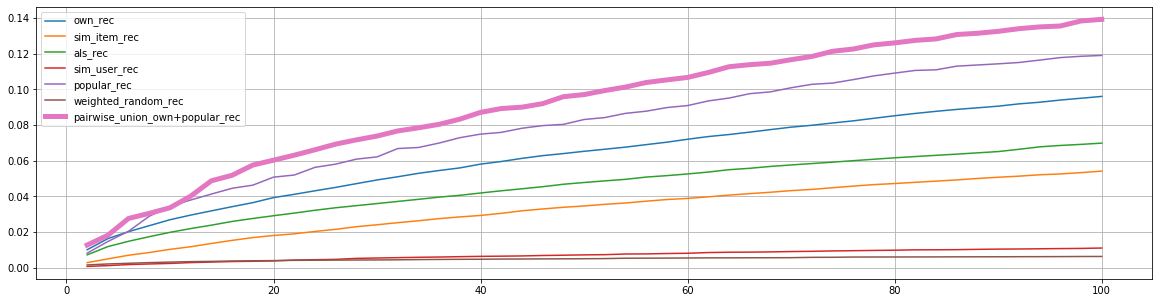

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(list_for_iter, list_own_rec, label='own_rec')

plt.plot(list_for_iter, list_sim_item_rec, label='sim_item_rec')
plt.plot(list_for_iter, list_als_rec, label='als_rec')
plt.plot(list_for_iter, list_sim_user_rec, label='sim_user_rec')

plt.plot(list_for_iter, list_popular_rec, label='popular_rec')
plt.plot(list_for_iter, list_weighted_random_rec, label='weighted_random_rec')

plt.plot(list_for_iter, list_union_rec, label='pairwise_union_own+popular_rec', linewidth=5)

plt.legend()
plt.grid()

### Precision@top_k of matching

In [30]:
list_own_rec_r = []
list_sim_item_rec_r = []
list_als_rec_r = []
list_sim_user_rec_r = []
list_popular_rec_r = []
list_weighted_random_rec_r = []
list_union_rec_r = []

for top_k in tqdm(list_for_iter):
    list_of_res = list(calc_precision(result_eval_matcher, top_k))
    
    list_own_rec_r.append(list_of_res[0][1])
    list_sim_item_rec_r.append(list_of_res[1][1])
    list_als_rec_r.append(list_of_res[2][1])
    list_sim_user_rec_r.append(list_of_res[3][1])
    
    list_popular_rec_r.append(list_of_res[4][1])
    list_weighted_random_rec_r.append(list_of_res[5][1])
    list_union_rec_r.append(list_of_res[6][1])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.49s/it]


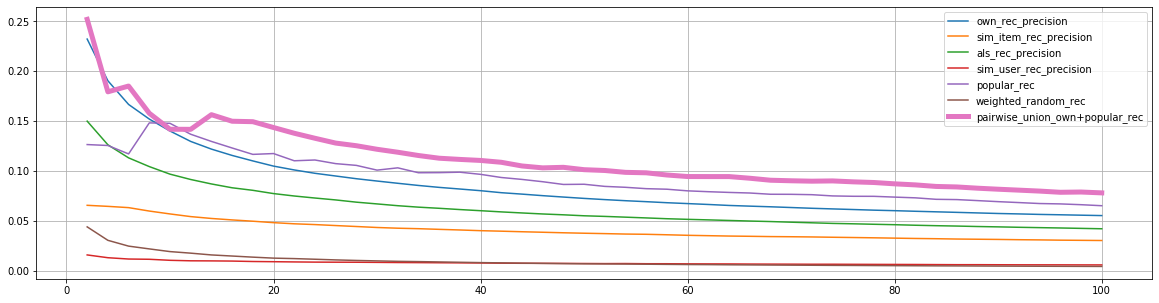

In [31]:
plt.figure(figsize=(20, 5))
plt.plot(list_for_iter, list_own_rec_r, label='own_rec_precision')

plt.plot(list_for_iter, list_sim_item_rec_r, label='sim_item_rec_precision')
plt.plot(list_for_iter, list_als_rec_r, label='als_rec_precision')
plt.plot(list_for_iter, list_sim_user_rec_r, label='sim_user_rec_precision')

plt.plot(list_for_iter, list_popular_rec_r, label='popular_rec')
plt.plot(list_for_iter, list_weighted_random_rec_r, label='weighted_random_rec')

plt.plot(list_for_iter, list_union_rec_r, label='pairwise_union_own+popular_rec', linewidth=5)
plt.legend()
plt.grid()

### Какие из них дают наибольший recall@k ?
#### Наибольший recall дают алгоритмы popular_rec и own_rec

### Дают ли own recommendtions + top-popular лучший recall? 
#### Да, данная комбинация дает лучший recall, если использовать попарное объединение элементов

In [32]:
# list1 = [1, 1, 1]
# list2 = [2, 3, 4]
# np.ravel([[i,j] for i, j in zip(list1, list2)])
# out #array([1, 2, 1, 3, 1, 4])

### B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  


#### При увеличении числа k значение метрики recall непрерывно возрастает, однако всё большее число k дает всё меньший прирост recall.

### C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

####  Слишком большое количество рекомендаций, скорее всего, пользователь не сможет просмотреть или потеряет интерес. К тому же при большом recall уменьшается precision. Слишком малое количество рекомендаций может его не удовлетворить. 
#### Полагаю, в целом для большинства случаев уместно от 5 до 10 (5 <= k <= 10) рекомендаций в одной выдаче, а затем предложение группы следующих рекомендаций при заинтересованности пользователя. А максимальное значение k = 30.

____________________________________________________

## Задание 2.

In [33]:
#precision@5 первого уровня на матчере
result_eval_matcher.apply(lambda row: precision_at_k(row['own_rec'], row['actual'], k=5), axis=1).mean()

0.17712691771268974

### Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [34]:
# 3 временных интервала
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

### Подготовка данных для трейна

In [35]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [36]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [37]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [38]:
len(df_match_candidates.candidates[0])

100

In [39]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [40]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [41]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


### Check warm start

In [42]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (215100, 2) Users: 2151 Items: 4585


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [43]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [44]:
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


####  Добавляем наших кандитатов в качестве нулей

In [45]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [46]:
df_ranker_train.target.value_counts()

0.0    200105
1.0     11886
Name: target, dtype: int64

In [47]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


In [48]:
df_ranker_train['target'].mean()

0.05606841799887731

### Подготавливаем фичи для обучения модели

In [49]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [50]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [51]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [52]:
data_train_ranker

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2282320,222,41297772783,635,1120741,1,0.59,304,0.00,1716,91,0.0,0.0
2282321,462,41297773713,635,993339,1,1.99,304,0.00,2040,91,0.0,0.0
2282322,462,41297773713,635,995242,1,1.00,304,-0.89,2040,91,0.0,0.0
2282323,462,41297773713,635,10180324,1,3.00,304,-0.29,2040,91,0.0,0.0


In [53]:
# Средний чек у каждого покупателя(пользователя)
mean_check = data_train_ranker.groupby(
    ['user_id', 'basket_id'], as_index=False).agg({'sales_value': 'sum'}).groupby(
        'user_id', as_index=False).agg({'sales_value': 'mean'}).rename(columns={'sales_value': 'mean_check'})

df_ranker_train = df_ranker_train.merge(mean_check , on='user_id', how='left')

In [54]:
# Кол-во покупок в каждой категории у каждого покупателя
df_tmp = data_train_ranker.merge(item_features, on='item_id', how='left')

quantity_purchases_in_cat = df_tmp.groupby(
    ['user_id', 'commodity_desc'], as_index=False).count()[['user_id', 'commodity_desc', 'item_id']].rename(
        columns={'item_id': 'quantity_purchases_in_cat'})
df_ranker_train = df_ranker_train.merge(quantity_purchases_in_cat, on=['user_id', 'commodity_desc'], how='left')

In [55]:
# Среднее кол-во покупок товара в неделю 
mean_purch_per_week = data_train_ranker.groupby(['item_id', 'week_no'], as_index=False).agg({"user_id": 'count'}).groupby(
     'item_id', as_index=False).agg({'user_id': 'mean'}).rename(columns={'user_id': 'mean_purch_per_week'})

df_ranker_train = df_ranker_train.merge(mean_purch_per_week, on='item_id', how='left')

In [56]:
# Среднее кол-во покупок 1 товара в категории в неделю
df_tmp = data_train_ranker.merge(item_features, on='item_id', how='left')

df_tmp = df_tmp.groupby(['commodity_desc', 'week_no'], as_index=False).agg({"user_id": 'count'}).groupby(
     'commodity_desc', as_index=False).agg({'user_id': 'mean'}).rename(columns={'user_id': 'mean_comm_per_week'})

df_ranker_train = df_ranker_train.merge(df_tmp, on='commodity_desc', how='left')
df_ranker_train

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,quantity_purchases_in_cat,mean_purch_per_week,mean_comm_per_week
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,NaN,1.000000,10.166667
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,NaN,1.000000,82.666667
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,1.0,NaN,59.000000
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,NaN,NaN,114.666667
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,1.0,2.000000,59.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211986,1745,844179,0.0,2852,MEAT,National,BEEF,PRIMAL,,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,13.970000,NaN,38.000000,483.333333
211987,1745,1044078,0.0,2845,MEAT,National,BEEF,LEAN,,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,13.970000,NaN,45.666667,483.333333
211988,1745,1070820,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,13.970000,NaN,59.500000,979.666667
211989,1745,1127831,0.0,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,13.970000,NaN,23.666667,50.833333


In [57]:
# (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)

df_tmp = data_train_ranker.merge(item_features, on='item_id', how='left')
tmp2 = df_tmp.groupby('item_id', as_index=False).agg({'sales_value': 'mean'})
df_tmp = df_tmp.groupby(['item_id', 'commodity_desc'], as_index=False).agg({"sales_value": 'sum'}).groupby(
    'item_id', as_index=False).agg({'sales_value': 'mean'}).rename(columns={'sales_value': 'mean_sales_item_per_cat'})

df_tmp = df_tmp.merge(tmp2, on='item_id', how='left')
df_tmp['mean_sales_item_per_cat-sales_value'] = df_tmp['mean_sales_item_per_cat'] - df_tmp['sales_value']
display(df_tmp.head(3))

df_ranker_train = df_ranker_train.merge(df_tmp[['item_id', 'mean_sales_item_per_cat-sales_value']], on='item_id', how='left')

,item_id,mean_sales_item_per_cat,sales_value,mean_sales_item_per_cat-sales_value
0,28116,0.33,0.33,0.0
1,28117,0.34,0.34,0.0
2,28143,0.33,0.33,0.0


In [58]:
# (Кол-во покупок юзером конкретной категории) / (Среднее кол-во покупок всеми юзерами конкретной категории)

df_tmp = data_train_ranker.merge(item_features, on='item_id', how='left')


tmp2 = df_tmp.groupby(['user_id', 'commodity_desc'], as_index=False).count().rename(columns={'basket_id': 'cnt_sales'})[['user_id', 'commodity_desc', 'cnt_sales']]

tmp3 = tmp2.groupby('commodity_desc', as_index=False).agg({'cnt_sales': 'mean'}).rename(columns={'cnt_sales': 'mean_sales_per_cat'})

tmp2 = tmp2.merge(tmp3, on='commodity_desc', how='left')

tmp2['cnt_sales-mean_sales_per_cat'] = tmp2['cnt_sales'] - tmp2['mean_sales_per_cat']
display(tmp2.head(3))

df_ranker_train = df_ranker_train.merge(tmp2[['user_id', 'commodity_desc', 'cnt_sales-mean_sales_per_cat']], on=['user_id', 'commodity_desc'], how='left')
df_ranker_train.head()

,user_id,commodity_desc,cnt_sales,mean_sales_per_cat,cnt_sales-mean_sales_per_cat
0,1,,1,1.826087,-0.826087
1,1,AIR CARE,3,1.933610,1.066390
2,1,APPLES,2,1.818018,0.181982


,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,quantity_purchases_in_cat,mean_purch_per_week,mean_comm_per_week,mean_sales_item_per_cat-sales_value,cnt_sales-mean_sales_per_cat
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,NaN,1.0,10.166667,13.300,NaN
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,NaN,1.0,82.666667,0.000,NaN
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,1.0,NaN,59.000000,NaN,-0.945055
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,NaN,NaN,114.666667,NaN,NaN
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,1.0,2.0,59.000000,79.101,-0.945055


In [59]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [60]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'mean_check',
 'quantity_purchases_in_cat',
 'mean_purch_per_week',
 'mean_comm_per_week',
 'mean_sales_item_per_cat-sales_value',
 'cnt_sales-mean_sales_per_cat']

### Обучение модели ранжирования

In [61]:
%%time
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Wall time: 5.93 s


In [62]:
df_ranker_predict = df_ranker_train.copy()

In [63]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [64]:
df_ranker_predict

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,quantity_purchases_in_cat,mean_purch_per_week,mean_comm_per_week,mean_sales_item_per_cat-sales_value,cnt_sales-mean_sales_per_cat,proba_item_purchase
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,Unknown,1,None/Unknown,14.355581,NaN,1.000000,10.166667,13.300000,NaN,0.000358
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,Unknown,1,None/Unknown,14.355581,NaN,1.000000,82.666667,0.000000,NaN,0.000286
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,Unknown,1,None/Unknown,14.355581,1.0,NaN,59.000000,NaN,-0.945055,0.050486
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,...,Unknown,1,None/Unknown,14.355581,NaN,NaN,114.666667,NaN,NaN,0.000068
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,...,Unknown,1,None/Unknown,14.355581,1.0,2.000000,59.000000,79.101000,-0.945055,0.123246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211986,1745,844179,0.0,2852,MEAT,National,BEEF,PRIMAL,,45-54,...,Single Male,2,None/Unknown,13.970000,NaN,38.000000,483.333333,1145.593333,NaN,0.000611
211987,1745,1044078,0.0,2845,MEAT,National,BEEF,LEAN,,45-54,...,Single Male,2,None/Unknown,13.970000,NaN,45.666667,483.333333,1283.787482,NaN,0.000859
211988,1745,1070820,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,...,Single Male,2,None/Unknown,13.970000,NaN,59.500000,979.666667,929.489076,NaN,0.000526
211989,1745,1127831,0.0,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,45-54,...,Single Male,2,None/Unknown,13.970000,NaN,23.666667,50.833333,644.697676,NaN,0.000669


## Evaluation on test dataset

In [65]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


### Eval matching on test dataset

In [66]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 11.8 s


In [67]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, 5), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1444117647058813)]

### Eval re-ranked matched result on test dataset
    

In [68]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [69]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [70]:
print(*sorted(calc_precision(result_eval_ranker, 5), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.18600522193211302)
('own_rec', 0.1444117647058813)


C:\Users\Anokiro\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


### Вырос ли precision@5 при использовании двухуровневой модели?

#### Да, показатель precision@5 вырос при использовании двухуровневой модели.